In [59]:
import tensorflow as tf
import h5py
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable

In [60]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [61]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

In [62]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1,])
    return image

In [63]:
new_train = x_train.map((normalize))
new_test = x_test.map((normalize))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [64]:
def one_hot_matrix(label, depth=6):
    return tf.reshape(tf.one_hot(label, depth), shape=[-1])

In [65]:
new_y_test = y_test.map((one_hot_matrix))
new_y_train = y_train.map(one_hot_matrix)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [66]:
def initialize_parameters():
    initializer = tf.keras.initializers.GlorotNormal(seed=1) 
    
    W1 = tf.Variable(initializer(shape=(25,12288)))
    b1 = tf.Variable(initializer(shape=(25,1)))
    
    W2 = tf.Variable(initializer(shape=(12,25)))
    b2 = tf.Variable(initializer(shape=(12,1)))
    
    W3 = tf.Variable(initializer(shape=(6,12)))
    b3 = tf.Variable(initializer(shape=(6,1)))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [67]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.math.add(tf.matmul(W1, X) ,b1)
    A1 = tf.keras.activations.relu(Z1)

    
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1) ,b2)
    A2 = tf.keras.activations.relu(Z2)
    
    
    Z3 = tf.math.add(tf.matmul(W3, A2) ,b3) 
    
    return Z3

In [68]:
def compute_cost(logits, labels):
    logits = tf.transpose(logits)
    labels = tf.reshape(tf.transpose(labels),[logits.shape[0],6])
    cost =  tf.reduce_mean(tf.keras.losses.categorical_crossentropy(labels, logits,from_logits=True))
    return cost

In [70]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    parameters = initialize_parameters()
    
    costs = []                                        
    train_acc = []
    test_acc = []
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    m = dataset.cardinality().numpy()
    
    minibatches = dataset.batch(minibatch_size)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    
    for epoch in range(num_epochs):
        
        epoch_cost = 0
        
        train_accuracy.reset_states()
        
    
        for (minibatch_X, minibatch_Y) in minibatches:
            
            with tf.GradientTape() as tape:
                
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                
                minibatch_cost = compute_cost(Z3, tf.transpose(minibatch_Y))
            
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            
            epoch_cost += minibatch_cost
        
        epoch_cost /= m
        
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print("Train accuracy:", train_accuracy.result())
            
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())
            
            costs.append(epoch_cost)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()
            
    return parameters, costs, train_acc, test_acc
             

In [71]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

Cost after epoch 0: 0.058313
Train accuracy: tf.Tensor(0.16574074, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.16666667, shape=(), dtype=float32)
Cost after epoch 10: 0.054369
Train accuracy: tf.Tensor(0.22222222, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.21666667, shape=(), dtype=float32)
Cost after epoch 20: 0.048992
Train accuracy: tf.Tensor(0.38518518, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.33333334, shape=(), dtype=float32)
Cost after epoch 30: 0.044844
Train accuracy: tf.Tensor(0.5009259, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.35, shape=(), dtype=float32)
Cost after epoch 40: 0.040374
Train accuracy: tf.Tensor(0.587037, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.49166667, shape=(), dtype=float32)
Cost after epoch 50: 0.035780
Train accuracy: tf.Tensor(0.6203704, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.53333336, shape=(), dtype=float32)
Cost after epoch 60: 0.031599
Train accuracy: tf.Tensor(0.6796296, shape=(), dtyp

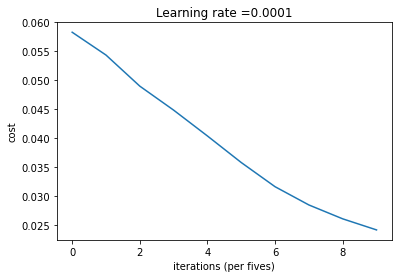

In [74]:
# Plot the cost
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


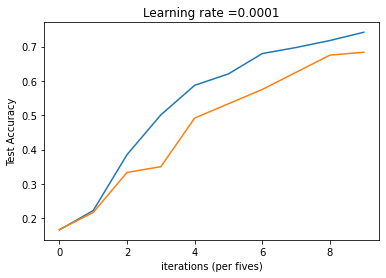

In [75]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()
